In [13]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
import albumentations as A
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random
import utils

In [14]:
# same seed
torch.manual_seed(0)

In [15]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [16]:
# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
batch_size = 10
threshold = 0.5

In [18]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        self.files = list(sorted(os.listdir("annotations_yolo/")))
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_image = self.files[idx][:-3] + 'jpg'
        file_label = self.files[idx][:-3] + 'xml'

        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        
        
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        
        image = image/255.0
        target = utils.generate_target(label_path)

        
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = torch.Tensor(transformed['image'])
            target = {'boxes':torch.Tensor(transformed['bboxes']).reshape(-1,4), 'labels':torch.Tensor(transformed['labels'])}
        else:
            image = torch.tensor(image,dtype=torch.float32)
        
        image = torch.unsqueeze(image, dim=0)
            
        return image, target 

In [19]:
dataset = ShipDataset(
        path = 'images/'
    )

train_set, val_set = torch.utils.data.random_split(dataset, [1500,359],)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, collate_fn=utils.collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,collate_fn=utils.collate_fn)


### Load RetinaNet

In [ ]:
model = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=2)
model.load_state_dict(torch.load("models/retTest3.pt"))
model.eval()
model.to(device)

### Load Resnet

In [52]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("models/faster300ep.pt"))
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [24]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = utils.make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 36/36 [00:46<00:00,  1.30s/it]


Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Inde

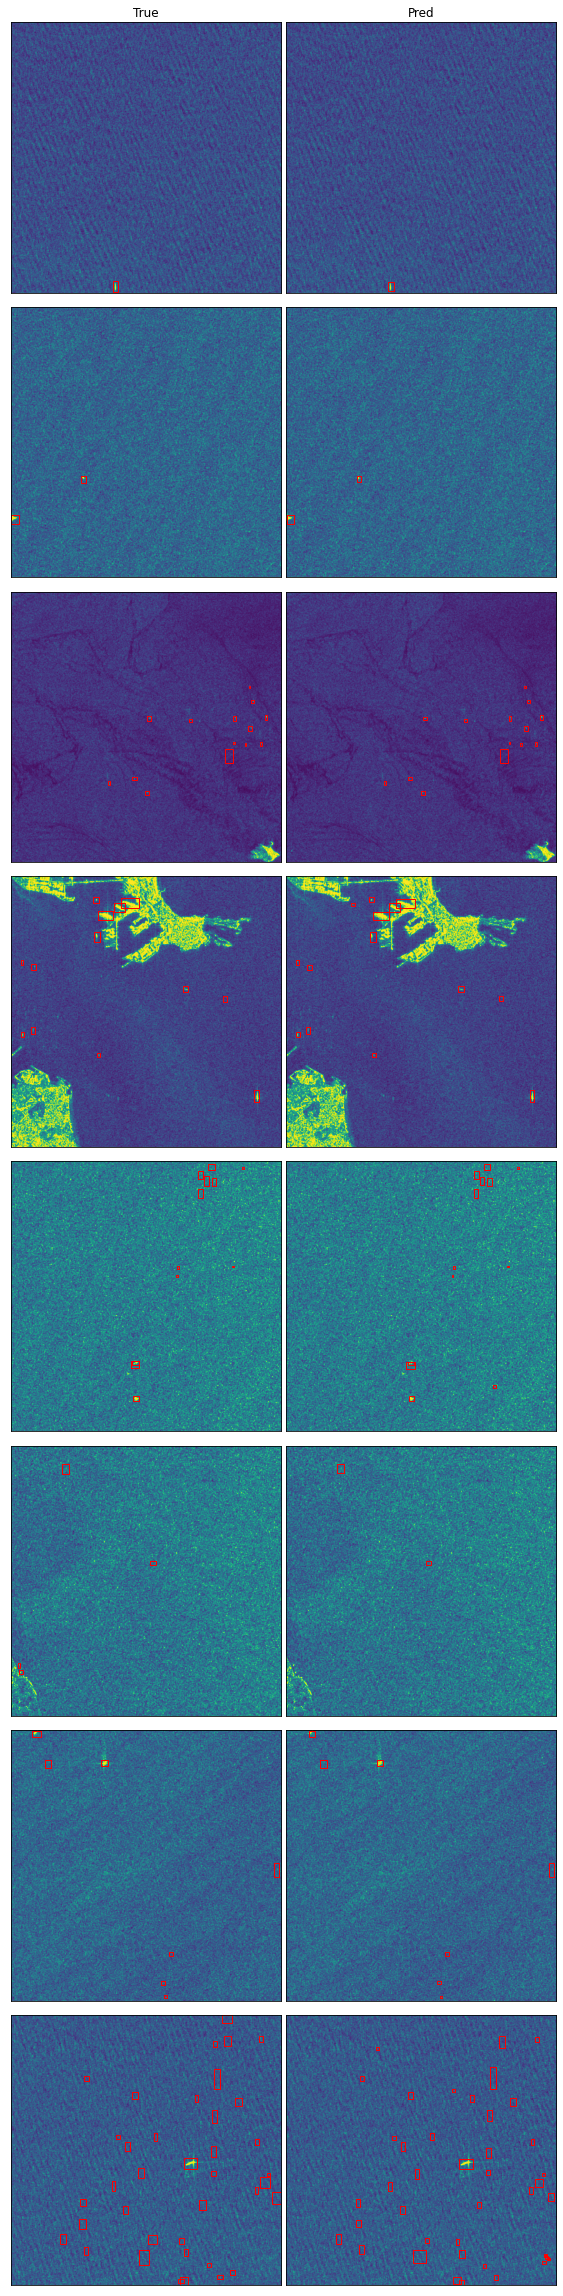

In [25]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in val_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = utils.plot_image_from_output2(im[sample_i], annot[sample_i])
        try:
            axes[(pos)//2, 1-((pos)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
            except:
                print("Index Error")
        img, rects = utils.plot_image_from_output2(im[sample_i], preds_adj_all[batch_i][sample_i])
        try:
            axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)
            except:
                print("Index Error")
        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()


In [26]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))] 
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))

/tmp/ipykernel_6026/1570812604.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


In [30]:
"Precision: {0} \n Recall: {1} \\n AP: {2} \n F1: {3}".format(precision.item(), recall.item(), AP.item(), f1.item())

'Precision: 0.8306389451026917.2F \n Recall: 0.8659710884094238 \\n AP: 0.845326033432146 \n F1: 0.8479371666908264'

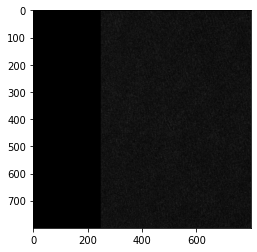

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
 
# Read Images
img = mpimg.imread("images/01_10_1.jpg")
 
# Output Images
plt.imshow(img)

In [55]:
image = cv2.imread("images/01_10_1.jpg",0)
image = image/255.0
image = torch.tensor(image,dtype=torch.float32)
image = torch.unsqueeze(image, dim=0)
image = image.to(device)
test = [image]

In [56]:
model(test)

[{'boxes': tensor([[472.5128, 799.8824, 654.0904, 800.0000]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.2438], device='cuda:0', grad_fn=<IndexBackward0>)}]